Import libraries

In [81]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Get the dataset

In [82]:
deposit_raw = pd.read_csv("deposit2019.csv")
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

Retrieve columns and rename columns

In [83]:
deposit = deposit_raw[["systemtranstime","transamount"]]
successfulVends = successfulVends_raw[["time","amount"]]
deposit= deposit.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Convert time to datetime

In [84]:
deposit['time']=pd.to_datetime(deposit.time)
successfulVends['time']=pd.to_datetime(successfulVends.time)

Normalization function

In [85]:
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(np.vstack(x))
    return x_scaled

Get number of transactions hourly

In [86]:
deposit_hour = deposit.resample('60min', on='time').count().drop('time',axis=1)

successfulVends_hour = successfulVends.resample('60min', on='time').count().drop('time',axis=1)

In [ ]:
deposit_hour = deposit

Normalize the number of transactions

In [87]:
deposit_hour['amount']=normalize(deposit_hour['amount'])
successfulVends_hour['amount']=normalize(successfulVends_hour['amount'])

Create model

Get the train and test dataset

In [88]:
train = deposit_hour[deposit_hour.index.month<3]
test = deposit_hour[deposit_hour.index.month==3]

### STL Decomposition

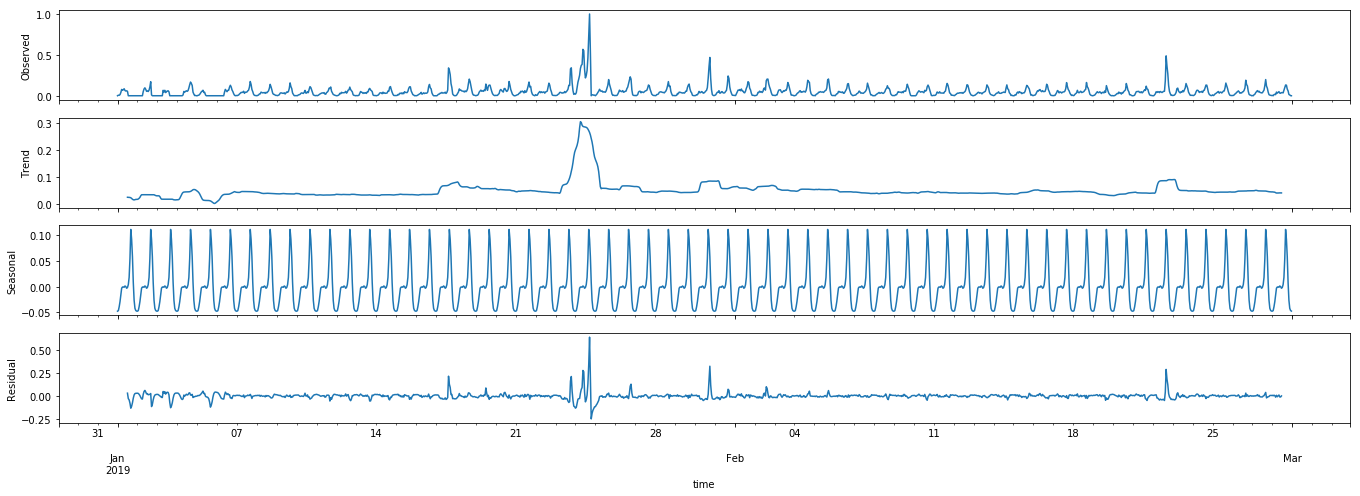

In [89]:
plt.rcParams['figure.figsize']=[19,7]
res = seasonal_decompose(train,model='additive')
resplot = res.plot()

It captures the seasonality.

### Classification Trees

In [90]:
deposit_hour.head()

,amount
time,
2018-12-31 21:00:00,0.024719
2018-12-31 22:00:00,0.010112
2018-12-31 23:00:00,0.012360
2019-01-01 00:00:00,0.000000
2019-01-01 01:00:00,0.006742


In [91]:
deposit_hour['hour'] = deposit_hour.index.hour
deposit_hour['day'] =  deposit_hour.index.day
deposit_hour['day_of_week'] =  deposit_hour.index.dayofweek

In [92]:
train_decompose = deposit_hour[deposit_hour.index.month<3]
test_decompose = deposit_hour[deposit_hour.index.month==3]

In [93]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
    
clf = RandomForestRegressor(max_depth=15, random_state=6,n_estimators=20)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.957079543525 			 0.34087787779


In [109]:
predictions= test
predictions['predictions'] = y_

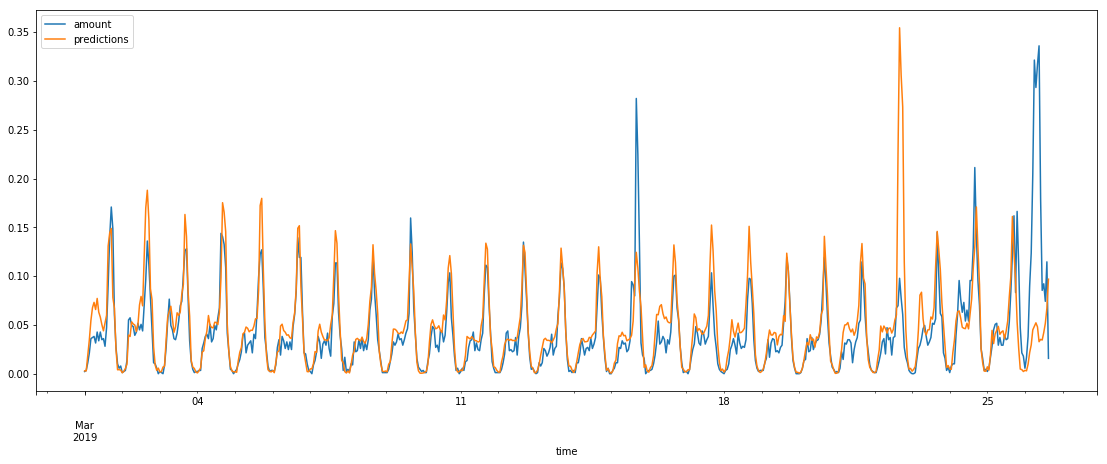

In [110]:
predictions.plot()

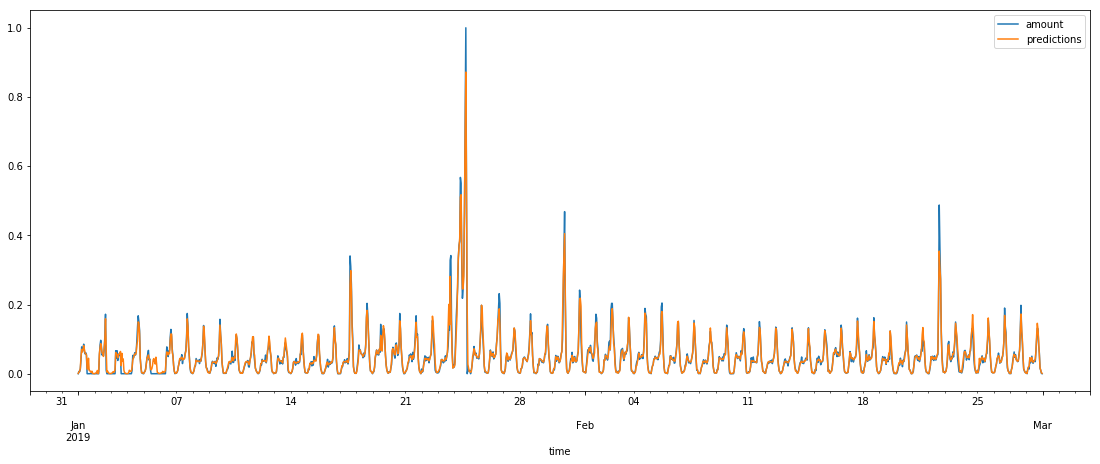

In [111]:
pred= train
pred['predictions'] = y_pred
pred.plot()